In [1]:
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl


from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

import lightgbm as lgb

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras import regularizers
from keras.losses import mse, binary_crossentropy

In [2]:
data = pd.read_csv("../input/creditcardfraud/creditcard.csv")

In [3]:
dataX = data.copy().drop(['Class','Time'],axis=1)

In [4]:
dataY = data['Class'].copy()

In [5]:
# Scale data
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True, with_mean=True, with_std=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])

In [6]:
# Split into train and test
X_train, X_test, y_train, y_test = \
train_test_split(dataX, dataY, test_size=0.33, \
random_state=2018, stratify=dataY)

In [7]:
# Drop 95% of the labels from the training set
toDrop = y_train[y_train==1].sample(frac=0.90,random_state=2018)
X_train.drop(labels=toDrop.index,inplace=True)
y_train.drop(labels=toDrop.index,inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [8]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - \
        np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [9]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'], \
            preds['anomalyScore'])
    average_precision = average_precision_score( \
        preds['trueLabel'], preds['anomalyScore'])
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: Average Precision = \
        {0:0.2f}'.format(average_precision))
    
    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the \
        curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    if returnPreds==True:
        return preds, average_precision

In [10]:
def precisionAnalysis(df, column, threshold):
    df.sort_values(by=column, ascending=False, inplace=True)
    threshold_value = threshold*df.trueLabel.sum()
    i = 0
    j = 0
    while i < threshold_value+1:
        if df.iloc[j]["trueLabel"]==1:
            i += 1
        j += 1
    return df, i/j

In [11]:
k_fold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2018)

In [12]:
params_lightGB = {
'task': 'train',
'application':'binary',
'num_class':1,
'boosting': 'gbdt',
'objective': 'binary',
'metric': 'binary_logloss',
'metric_freq':50,
'is_training_metric':False,
'max_depth':4,
'num_leaves': 31,
'learning_rate': 0.01,
'feature_fraction': 1.0,
'bagging_fraction': 1.0,
'bagging_freq': 0,
'bagging_seed': 2018,
'verbose': 0,
'num_threads':16
}

In [13]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[], index=y_train.index,columns=['prediction'])
for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:],X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index],y_train.iloc[cv_index]
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=2000,
    valid_sets=lgb_eval, early_stopping_rounds=200)
    loglossTraining = log_loss(y_train_fold, gbm.predict(X_train_fold, num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration)
    loglossCV = log_loss(y_cv_fold,predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)


[1]	valid_0's binary_logloss: 0.00328814
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.00501798
[3]	valid_0's binary_logloss: 0.0113596
[4]	valid_0's binary_logloss: 0.0134411
[5]	valid_0's binary_logloss: 0.0120885
[6]	valid_0's binary_logloss: 0.0118795
[7]	valid_0's binary_logloss: 0.0123715
[8]	valid_0's binary_logloss: 0.0112126
[9]	valid_0's binary_logloss: 0.0111943
[10]	valid_0's binary_logloss: 0.0110223
[11]	valid_0's binary_logloss: 0.0119001
[12]	valid_0's binary_logloss: 0.011144
[13]	valid_0's binary_logloss: 0.0108834
[14]	valid_0's binary_logloss: 0.0103315
[15]	valid_0's binary_logloss: 0.010241
[16]	valid_0's binary_logloss: 0.0102127
[17]	valid_0's binary_logloss: 0.0101784
[18]	valid_0's binary_logloss: 0.0101528
[19]	valid_0's binary_logloss: 0.0103359
[20]	valid_0's binary_logloss: 0.0103066
[21]	valid_0's binary_logloss: 0.010272
[22]	valid_0's binary_logloss: 0.0102553
[23]	valid_0's binary_logloss: 0.0102284
[24]	

In [14]:
loglossLightGBMGradientBoosting = log_loss(y_train, predictionsBasedOnKFolds.loc[:,'prediction'])
print('LightGBM Gradient Boosting Log Loss: ',loglossLightGBMGradientBoosting)

LightGBM Gradient Boosting Log Loss:  0.002397782774006999


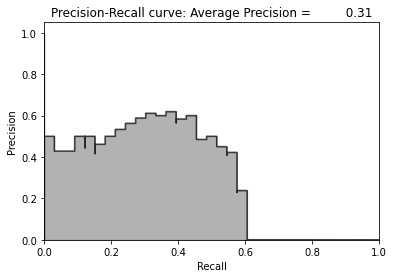

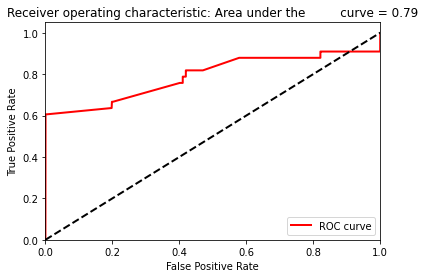

In [15]:
preds, average_precision = plotResults(y_train,predictionsBasedOnKFolds.loc[:,'prediction'], True)


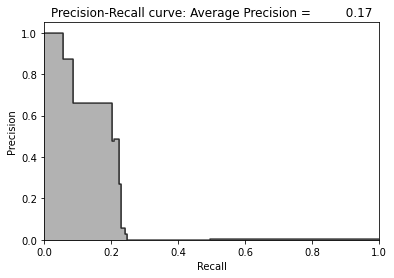

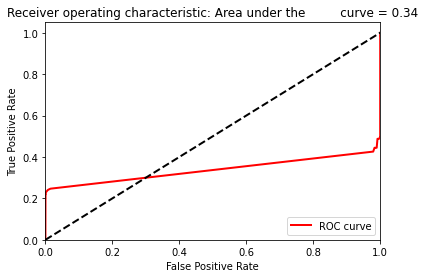

In [16]:
predictions = pd.Series(data=gbm.predict(X_test, num_iteration=gbm.best_iteration), index=X_test.index)
preds, average_precision = plotResults(y_test, predictions, True)

In [17]:
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print("Precision at 75% recall", precision)

Precision at 75% recall 0.0013093742681343013


In [18]:
oversample_multiplier = 100

X_train_original = X_train.copy()
y_train_original = y_train.copy()
X_test_original = X_test.copy()
y_test_original = y_test.copy()

X_train_oversampled = X_train.copy()
y_train_oversampled = y_train.copy()
X_train_oversampled = X_train_oversampled.append( \
        [X_train_oversampled[y_train==1]]*oversample_multiplier, \
        ignore_index=False)
y_train_oversampled = y_train_oversampled.append( \
        [y_train_oversampled[y_train==1]]*oversample_multiplier, \
        ignore_index=False)

X_train = X_train_oversampled.copy()
y_train = y_train_oversampled.copy()

In [19]:

model = Sequential()
model.add(Dense(units=40, activation='linear', \
                activity_regularizer=regularizers.l1(10e-5), \
                input_dim=29,name='hidden_layer'))
model.add(Dropout(0.02))
model.add(Dense(units=29, activation='linear'))

In [20]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [21]:

num_epochs = 5
batch_size = 32

history = model.fit(x=X_train, y=X_train,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.20,
                    verbose=1)

Epoch 1/5
4846/4846 [==============================] - 6s 1ms/step - loss: 0.0761 - accuracy: 0.8656 - val_loss: 0.0091 - val_accuracy: 0.9839
Epoch 2/5
4846/4846 [==============================] - 6s 1ms/step - loss: 0.0183 - accuracy: 0.9276 - val_loss: 0.0334 - val_accuracy: 0.9844
Epoch 3/5
4846/4846 [==============================] - 6s 1ms/step - loss: 0.0172 - accuracy: 0.9270 - val_loss: 0.0236 - val_accuracy: 0.9799
Epoch 4/5
4846/4846 [==============================] - 6s 1ms/step - loss: 0.0180 - accuracy: 0.9271 - val_loss: 0.0153 - val_accuracy: 0.9795
Epoch 5/5
4846/4846 [==============================] - 6s 1ms/step - loss: 0.0170 - accuracy: 0.9280 - val_loss: 0.1656 - val_accuracy: 0.9510


5954/5954 [==============================] - 4s 675us/step


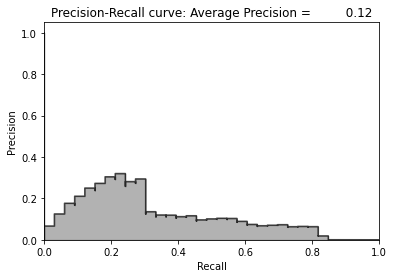

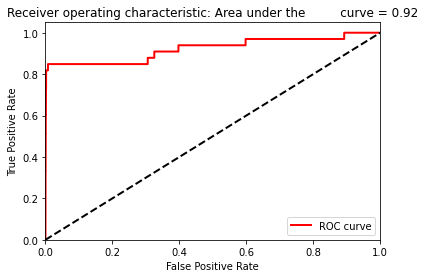

In [22]:

predictionsTrain = model.predict(X_train_original, verbose=1)
anomalyScoresAETrain = anomalyScores(X_train_original, predictionsTrain)
preds, average_precision = plotResults(y_train_original, \
                                      anomalyScoresAETrain, True)

2938/2938 [==============================] - 2s 678us/step


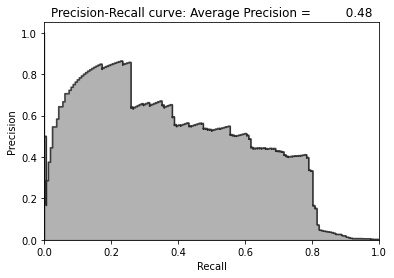

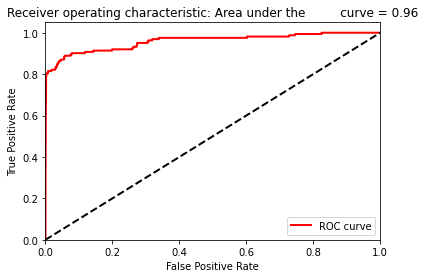

In [23]:
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds, average_precision = plotResults(y_test, anomalyScoresAE, True)